In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import yaml
import random
%matplotlib inline
sns.set_style('whitegrid')
torch.manual_seed(42)
random.seed(42)

In [2]:
import sys
sys.path.append('../')
import tcr_embedding as tcr

# Initialization

Set paths and names of the pre-trained models.

In [3]:
path_base = '../saved_models/icml/covid/'

path_poe_10x = path_base + 'covid_poe_transformer_10xWeights.pt'
path_cc_10x = path_base + 'covid_concat_transformer_10xWeights.pt'

path_poe_balanced = path_base + 'covid_poe_transformer_balancedWeights.pt'
path_cc_balanced = path_base + 'covid_concat_transformer_balancedWeights.pt'

path_sgTr = path_base + 'covid_tcr_transformer.pt'
path_sgRNA = path_base + 'covid_scRna.pt'

# Calculate Latent spaces

This method is used to calculate the latent space of a model indicated by its name.

In [4]:
def get_latent(modality, data):
    paths = {
        'poe_10x': path_poe_10x,
        'cc_10x': path_cc_10x,
        
        'poe_balanced': path_poe_balanced,
        'cc_balanced': path_cc_balanced,
        
        'RNA': path_sgRNA,
        'TCR': path_sgTr,
    }
    
    models = {        
        'poe_10x': 'PoE', #tcr.models.poe.PoEModel,
        'cc_10x': 'concat',#tcr.models.separate_model.SeparateModel,        
        
        'poe_balanced': 'PoE', #tcr.models.poe.PoEModel,
        'cc_balanced': 'concat', #tcr.models.separate_model.SeparateModel,        
        
        'RNA': 'RNA', # tcr.models.single_model.SingleModel,
        'TCR': 'single', # tcr.models.single_model.SingleModel,
    }   

    model_type = models[modality]
    file_path = paths[modality]
    
    model_file = torch.load(file_path)
    params = model_file['params']
    model = tcr.utils_training.init_model(params, model_type=model_type, adata=data, dataset_name='covid')
    model.load(file_path)

    groups = ['T_cells', 'reactive_combined', 'condition']
    latent = model.get_latent([data], batch_size=512, metadata=groups)
    latent.obs['IFNG'] = data.obs_vector('IFNG')
    return latent


# Quantitative Evaluation

The following provides the quantitative clustering analysis of the pre-trained models by the following steps:
1. The data is loaded
2. The latent spaces are calculated
3. The clustering scores are evaluted as the maximum score across three different leiden resolution parameters

We report the silhouette score as internal clustering metric indicating intra-cluster homogenity vs inter-clutser seperation and Normalized Mutual Information as external metric to the cell type and reactivity towards a SARS-CoV-2 antigen mix indicating cluster purity compared to completeness.

In [5]:
adata = sc.read_h5ad('../data/Covid/04_covid_highly_var_5000.h5ad')
# adata = adata[adata.obs['set'] == 'train']

In [6]:
latent_poe_10x = get_latent('poe_10x', adata)
latent_cc_10x = get_latent('cc_10x', adata)

latent_poe_balanced = get_latent('poe_balanced', adata)
latent_cc_balanced = get_latent('cc_balanced', adata)

latent_tcr = get_latent('TCR', adata)
latent_rna = get_latent('RNA', adata)

In [7]:
import sys
sys.path.append('..')
import tcr_embedding.evaluation.Clustering as Eval
import pandas as pd

In [8]:
def run_cluster_analysis(latent_space, name_label, cluster_params):

    labels_true = latent_space.obs[name_label].to_numpy()
    labels_predicted = Eval.predict_clustering(latent_space, cluster_params)

    scores = Eval.get_clustering_scores(latent_space.X, labels_true, labels_predicted)
    return scores

In [9]:
latent_spaces = {
        'poe': latent_poe_balanced,
        'cc': latent_cc_balanced,
        'RNA': latent_rna,
        'TCR': latent_tcr,
}

In [10]:
def extract_reactivity(value):
    if 'un-reactive' in value:
        return 'un-reactive'
    if 'CD8' in value:
        return 'CD8 reactive'
    if 'CD4' in value:
        return 'CD4 reactive'
    

In [11]:
def results_by_resolution(column):
    summary = {}
    for key, val in latent_spaces.items():
        val.obs['reactivity'] = [extract_reactivity(x) for x in val.obs['reactive_combined']]
        scores = []
        for res in [0.01, 0.1, 1]:
            cluster_params = {
                'num_neighbors': 15,
                'resolution': res
            }
            
            score = run_cluster_analysis(val, column, cluster_params)
            scores.append(score)
        max_summary = {}

        for metric in scores[0].keys():
            scores_per_metric = [sc[metric] for sc in scores]
            max_value = max(scores_per_metric)
            max_summary[metric] = max_value
        summary[key] = max_summary
    print(len(val))
    results = pd.DataFrame(summary)
    order = ['RNA', 'TCR', 'cc', 'cc2_5', 'poe', 'poe2_5']
    for el in order:
        if el not in summary.keys():
            order.remove(el)
    results = results[order]
    return results

In [12]:
results_cell_type = results_by_resolution('T_cells')
results_cell_type

6713


,RNA,TCR,cc,poe
ASW,-0.005361,0.092208,0.789748,0.185799
AMI,0.109748,0.311074,0.208004,0.365213
NMI,0.110494,0.312223,0.208324,0.366488
ARI,0.050981,0.430314,0.161445,0.518099


In [13]:
results_reactivity = results_by_resolution('reactivity')
results_reactivity

6713


,RNA,TCR,cc,poe
ASW,-0.005361,0.092208,0.789748,0.185799
AMI,0.024076,0.185375,0.040412,0.239764
NMI,0.025919,0.188899,0.041363,0.243520
ARI,0.000562,0.144162,0.104586,0.191869


# Differential Expressed Gene Analysis

Detect the highly expressed genes in the raw data set to see whether these are preserved in the trained models

In [14]:
from tcr_embedding.utils_training import determine_marker_genes

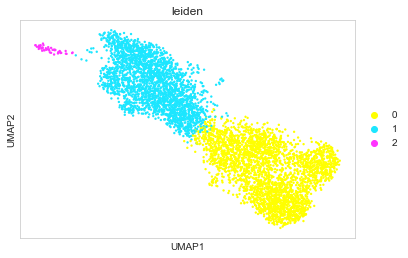

Trying to set attribute `.uns` of view, copying.


['PABPC1', 'CCL5', 'CCL4']

In [15]:
marker_genes = determine_marker_genes(adata, resolution=0.3, visualize=True)
marker_genes

# UMPAS

The following shows the UMAP visualization of the differen models. The UMAP parameter n_neighbors and min_distance are optimized visually per model.

In [16]:
def plot_umaps(adata, n_neighbors=15, min_dist=0.5, title=''):
    adata_tmp = adata.copy()
    sc.pp.neighbors(adata_tmp, n_neighbors=n_neighbors, random_state=42, use_rep='X')
    sc.tl.umap(adata_tmp, min_dist=min_dist, random_state=42)

    groups = ['T_cells', 'reactive_combined'] + marker_genes
    for col in groups:
        if col in marker_genes:
            sc.pl.umap(adata_tmp, color=col, title=title, color_map=sns.color_palette("viridis", as_cmap=True))
        else:
            sc.pl.umap(adata_tmp, color=col, title=title)

Subsample unreactive cells to same amount as reactive size for nicer UMAP visualization.

In [17]:
np.random.seed(42)

In [18]:
adata = sc.read_h5ad('../data/Covid/04_covid_highly_var_5000.h5ad')
adata = adata[adata.obs['set'] == 'train']

do_subsample = True
if do_subsample:
    reactive_states = ['CD4 reactive (unstimulated)', 
                       'CD8 reactive (unstimulated)', 
                       'CD8 reactive (stimulated)', 
                       'CD4 reactive (stimulated)']
    adata_reactive = adata[adata.obs['reactive_condition'].isin(reactive_states)]
    adata_unreactive = adata[~adata.obs['reactive_condition'].isin(reactive_states)]
    p = len(adata_reactive)/len(adata_unreactive)
    downsample_mask =  np.random.choice([True, False], size=len(adata_unreactive), replace=True, p=[p, 1-p])
    adata_unreactive = adata_unreactive[downsample_mask]
    adata_subsample = adata_reactive.concatenate([adata_unreactive])
else:
    adata_subsample = adata
adata_subsample.uns['aa_to_id'] = adata.uns['aa_to_id']

In [19]:
latent_poe_balanced = get_latent('poe_balanced', adata_subsample)
latent_cc_balanced = get_latent('cc_balanced', adata_subsample)

latent_tcr = get_latent('TCR', adata_subsample)
latent_rna = get_latent('RNA', adata_subsample)

Add marker genes to adata object containing the latent space for visualization

In [20]:
latent_spaces = [
    latent_poe_balanced,
    latent_cc_balanced,
    latent_tcr,
    latent_rna
]

In [21]:
for gene in marker_genes:
    for latent in latent_spaces:
        latent.obs[gene] = adata_subsample.obs_vector(gene)

... storing 'dataset' as categorical
... storing 'T_cells' as categorical
... storing 'reactive_combined' as categorical
... storing 'condition' as categorical


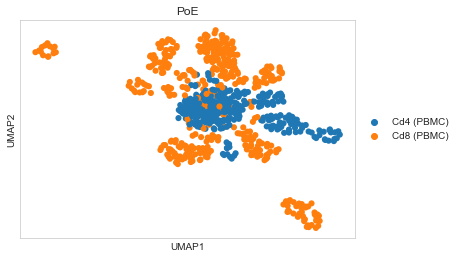

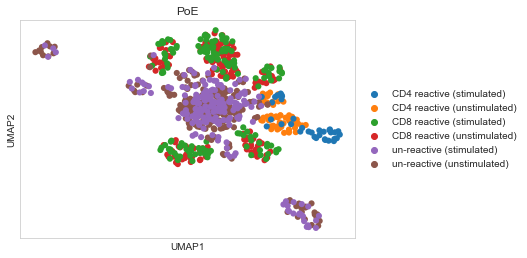

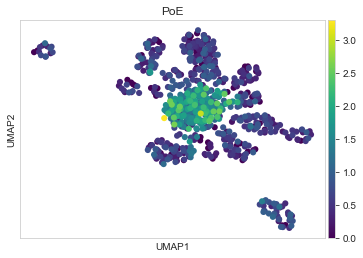

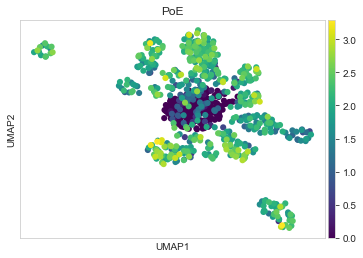

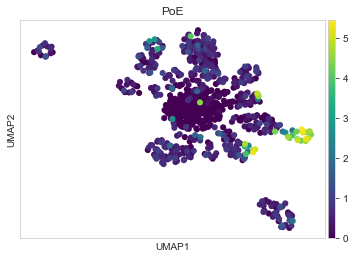

In [22]:
plot_umaps(latent_poe_balanced, n_neighbors=25, min_dist=2., title=f'PoE')

... storing 'dataset' as categorical
... storing 'T_cells' as categorical
... storing 'reactive_combined' as categorical
... storing 'condition' as categorical


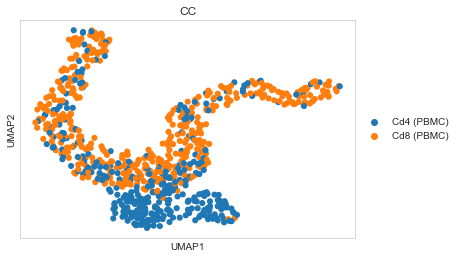

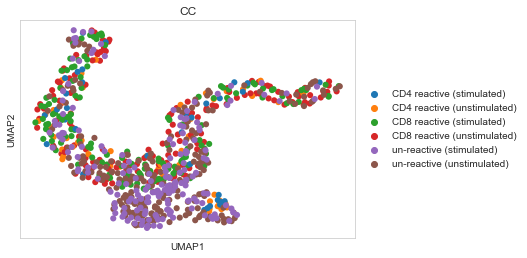

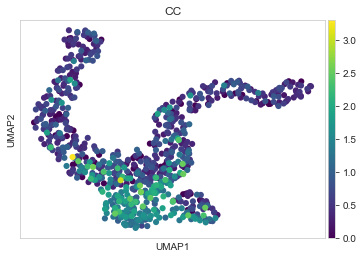

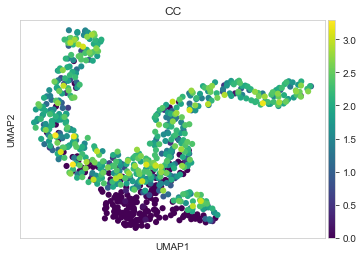

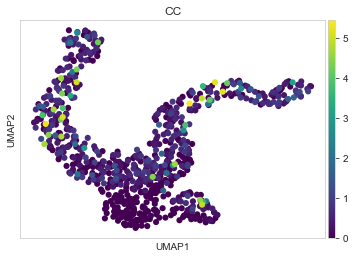

In [23]:
plot_umaps(latent_cc_balanced, n_neighbors=50, min_dist=2., title=f'CC')

... storing 'dataset' as categorical
... storing 'T_cells' as categorical
... storing 'reactive_combined' as categorical
... storing 'condition' as categorical


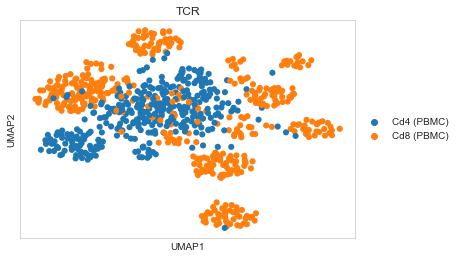

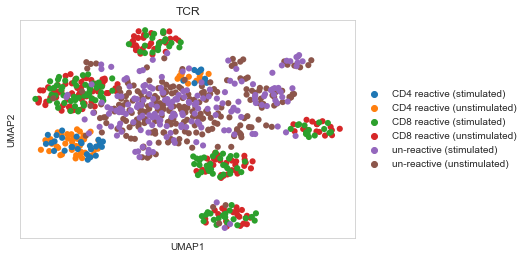

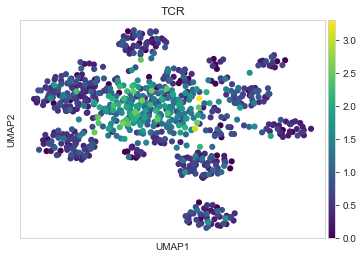

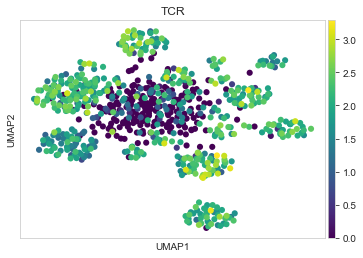

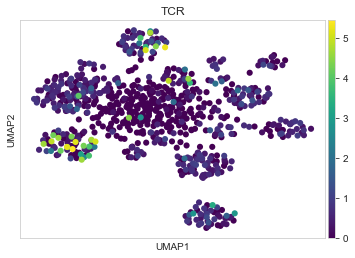

In [24]:
plot_umaps(latent_tcr, n_neighbors=25, min_dist=1., title=f'TCR')

... storing 'dataset' as categorical
... storing 'T_cells' as categorical
... storing 'reactive_combined' as categorical
... storing 'condition' as categorical


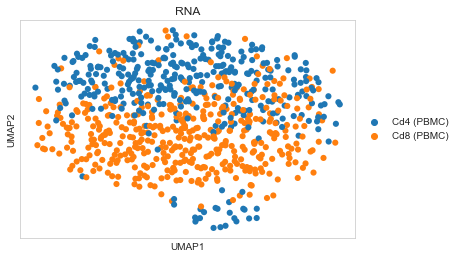

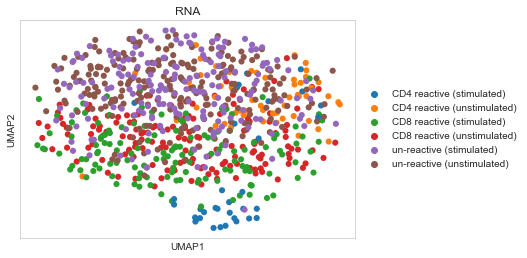

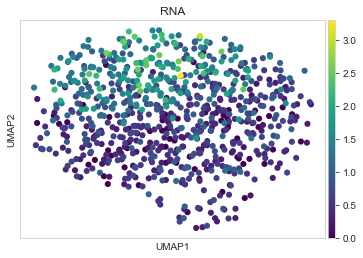

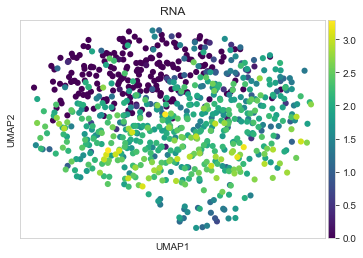

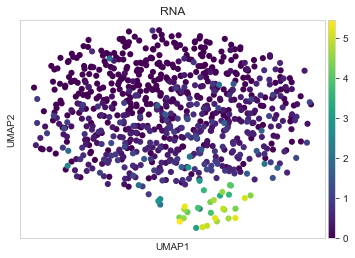

In [25]:
plot_umaps(latent_rna, n_neighbors=25, min_dist=1., title=f'RNA')